# Problem Set 3

# Problem 3: Medical Diagnostics

These data sets were generated using the UCI SPECT heart data set (follow the link for information about the format of the data).

In [ ]:
import numpy as np
import collections
import math
import matplotlib.pyplot as plt

heart_train_path = r'./heart_train.data'
heart_test_path = r'./heart_test.data'
train = np.loadtxt(heart_train_path, delimiter=",")
test = np.loadtxt(heart_test_path, delimiter=",")

X_train = train[:, 1:]
y_train = train[:, 0]
y_train[y_train == 0] = -1

X_test = test[:, 1:]
y_test = test[:, 0]
y_test[y_test == 0] = -1

## Suppose that the hypothesis space consists of all decision trees with exactly three attribute splits (repetition along the same path is allowed) for this data set.

### Run the adaBoost algorithm for five rounds to train a classifier for this data set.

In [ ]:
# Functions to build the hypothesis space

class DecisionTree():
    def __init__(self, root):
        self.root = root
    def __predict(self, root, x):
        if root.label is not None:
            return root.label
        return self.__predict(root.children[x[root.attr]], x)    
    def predict(self, x):
        if self.root.label is not None:
            return self.root.label
        return self.__predict(self.root.children[x[self.root.attr]], x)


class Node():
    def __init__(self, attr, children = None, label = None):
        self.attr = attr
        self.children = children
        self.label = label

# Recursively builds all possible trees given three attributes
# Children = list of attribute indicies that will be children of the current root
# attr = index of the attribute of the current node
# Returns a list of root nodes for each tree
def build3split(children, attr):
    trees = []

    # Just leafs
    if len(children) == 0:
        for left_value in [-1, 1]:
            for right_value in [-1, 1]:
                left_leaf = Node(attr, label=left_value)
                right_leaf = Node(attr, label=right_value)
                trees.append(Node(attr, children={0 : left_leaf, 1 : right_leaf}))
        return trees

    # Single Child Node
    single_subtrees = build3split(children[1:], children[0])
    for subtree in single_subtrees:
        for leaf_value in [-1, 1]:
            leaf = Node(attr, label=leaf_value)
            trees.append(Node(attr, children={0 : subtree, 1 : leaf}))
            trees.append(Node(attr, children={0 : leaf, 1 : subtree}))

    # Two Child Node
    if (len(children) >= 2):
        left_subtrees = build3split(children[2:], children[0])
        right_subtrees = build3split(children[2:], children[1])

        for left_tree in left_subtrees:
            for right_tree in right_subtrees:
                trees.append(Node(attr, children={0 : left_tree, 1 : right_tree}))

    return trees

In [ ]:
# Functions to implement AdaBoosting

# Prints a tree given the root node
def print_tree(root, prefix="├──"):
    if root is None:
        return
    if root.label is not None:
        print(f"{root.label}")
        return
    print(f"Split on index: {root.attr}")
    for attr, child in root.children.items():
        print(f"\t{prefix}Attr: {attr} => ", end="")
        print_tree(child, "\t"+ prefix )
    return

# Calculates the accuracy of a ensemble of hypotheses in boosting
# ensemble = list of tuples (alpha, model)
def ensemble_accuracy(ensemble, X, y):
    result = []
    for x in X:
        y_pred = 0
        for alpha, model in ensemble:
            y_pred += alpha * model.predict(x)
        result.append(y_pred)
    result = np.sign(result)
    return np.sum(np.equal(result, y)) / len(y)

# Perform Adaboosting on a given hypothesis space for fixed iterations
# hypo_space = list of possible hypotheses
# iter = number of boosting iterations to perform
# train = (X_train, y_train)
# test = (X_test, y_test)
# Returns (ensemble list, training accuracy list, test accuracy list)
def adaboost(hypo_space, iter, train, test):
    X_train = train[0]
    y_train = train[1]
    weights = np.array([1 / len(y_train)] * len(y_train)) # Initalize weights
    ensemble = [] # List of (alphas, models) for each iteration

    # list of arrays of predicted y's for each hypothesis
    hypo_predictions =[np.array([hypo.predict(x) for x in X_train]) for hypo in hypo_space]
    
    # 2-d array where each row is a boolean array if the prediction is wrong
    error_masks = np.array([predictions != y_train for predictions in hypo_predictions])

    # accuracy per iteration
    train_acc = []
    test_acc = []

    # Perform boosting for n iterations
    for i in range(iter):

        # Calculate error for each possible hypothesis
        # [np.sum(mask * weights) for mask in error_masks] 
        weighted_errors = np.dot(error_masks, weights)
        index_min = np.argmin(weighted_errors)
        
        best_error = weighted_errors[index_min]
        best_hypo = hypo_space[index_min]
        best_predictions = hypo_predictions[index_min]


        # Calculate h(x) for new weights
        y_pred = best_predictions

        # Calucate alpha
        alpha = 0.5 * np.log((1 - best_error) / best_error)

        # Update weights
        weights = (weights * np.exp(-y_train * y_pred * alpha)) / (2 * np.sqrt(best_error * (1 - best_error)))
        ensemble.append((alpha, best_hypo))
        
        # Calculate Accuracy
        train_acc.append(ensemble_accuracy(ensemble, train[0], train[1]))
        test_acc.append(ensemble_accuracy(ensemble, test[0], test[1]))

        # Print metrics for first five iterations
        if i < 5:
            print(f"Iteration: {i}\tError:{best_error}\tAlpha:{alpha}")
            print_tree(best_hypo.root)

    return ensemble, train_acc, test_acc

In [ ]:
# Builds the hypothesis space
hypo_roots = []
# Iterates through all possible attributes for each split
for i in range(len(X_train[0])):
    for j in range(len(X_train[0])):
        for k in range(len(X_train[0])):
            hypo_roots += build3split([j, k], i)

# Encapsulates the nodes into a DecisionTree
hypo_space = [DecisionTree(root) for root in hypo_roots]
print(len(hypo_space))

# Performs Adaboost
ensemble, train_acc, test_acc = adaboost(hypo_space, 10, (X_train, y_train), (X_test, y_test))

851840
Iteration: 0	Error:0.1875	Alpha:0.7331685343967135
Split on index: 7
	├──Attr: 0 => Split on index: 10
		├──Attr: 0 => Split on index: 15
			├──Attr: 0 => -1
			├──Attr: 1 => 1
		├──Attr: 1 => 1
	├──Attr: 1 => 1
Iteration: 1	Error:0.2692307692307692	Alpha:0.4992644150555637
Split on index: 11
	├──Attr: 0 => Split on index: 19
		├──Attr: 0 => Split on index: 21
			├──Attr: 0 => -1
			├──Attr: 1 => 1
		├──Attr: 1 => 1
	├──Attr: 1 => 1
Iteration: 2	Error:0.34035087719298246	Alpha:0.33086549216328326
Split on index: 12
	├──Attr: 0 => Split on index: 2
		├──Attr: 0 => Split on index: 21
			├──Attr: 0 => 1
			├──Attr: 1 => -1
		├──Attr: 1 => -1
	├──Attr: 1 => 1
Iteration: 3	Error:0.33719604863221886	Alpha:0.33790736963862894
Split on index: 3
	├──Attr: 0 => Split on index: 21
		├──Attr: 0 => -1
		├──Attr: 1 => 1
	├──Attr: 1 => Split on index: 8
		├──Attr: 0 => -1
		├──Attr: 1 => 1
Iteration: 4	Error:0.36971122376230825	Alpha:0.2667279323771729
Split on index: 4
	├──Attr: 0 => 1
	├──At

![trees](https://drive.google.com/uc?export=download&id=1DE3XPpgmxM2sIH1ZXxbStwx3_PCG4hue)

### (b) Run the adaBoost algorithm for 10 rounds of boosting. Plot the accuracy on the training and test sets versus iteration number.

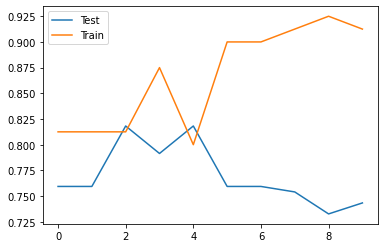

In [ ]:
plt.plot(test_acc, label="Test")
plt.plot(train_acc, label="Train")
plt.legend()

## 2. Now, suppose that the hypothesis space consists of only height 1 decision trees for this dataset.


In [ ]:
# Construct the hypothesis space

class DecisionTreeSingle():
    def __init__(self, attr, result):
        self.root = None
        self.attr = attr
        self.result = result
        return

    def predict(self, X):

        # Return scalar
        if (len(X.shape) == 1):
            return self.result.get(X[self.attr])

        # Return array
        prediction = []
        for x in X:
            prediction.append(self.result.get(x[self.attr]))
        return np.array(prediction)

hypothesis = []

hypothesis.append(DecisionTreeSingle(0, {0:1, 1:1}))
hypothesis.append(DecisionTreeSingle(0, {0:-1, 1:-1}))

for i in range(X_train.shape[1]):
    split = {0:1, 1:-1}
    hypothesis.append(DecisionTreeSingle(i, split))
    split = {0:-1, 1:1}
    hypothesis.append(DecisionTreeSingle(i, split))

### (a) Use coordinate descent to minimize the exponential loss function for this hypothesis space over the training set. 

In [ ]:
# Initial alphas = 0's
# Stopping condition: when the max change in alpha between a pass through all 
# the hypotheses is less than 1e-5

# Any alphas that are 1e-10 away from 0 are truncated to exactly 0
# 1e-5 takes around 15 mins while 1e-4 takes around 2 mins
# The final alphas would be different but the test accuracy is the exact same

def coord_descent(hypothesis, X_train, y_train):
    old_alphas = [0] * len(hypothesis)
    alphas = [0] * len(hypothesis)
    iter_diff = 1
    predictions = [hypo.predict(X_train) for hypo in hypothesis]    # predicted y's for each hypothesis
    correct_masks = [prediction == y_train for prediction in predictions]   # boolean masks of correct predicted y's and true y's 

    while iter_diff > 1e-5:

        # A round of going through all the hypotheses to calculate new alpha
        for i, correct_mask in enumerate(correct_masks):
            # Instead of directly iterating through each hypothesis
            # We iterate through the arrays of correct/incorrect boolean masks
            # This cacheing step saves from repredicting X_train and is equivalent to:
            # correct_mask = hypo.predict(X_train) == y_train
            # 1. sum_{t != t'} a_t h_t(x^m)
            hypo_summation = np.zeros(len(y_train))

            for j, prediction in enumerate(predictions):
                if i == j:
                    continue
                if alphas[j] == 0:
                    continue
                hypo_summation += alphas[j] * prediction

            # 2. exp(-y^m times summation)
            exp_summation = np.exp(-y_train * hypo_summation)
                    
            # 3. Sum up all correctly and incorrectly classified points separately
            correct_sum = np.sum(exp_summation[correct_mask])
            incorrect_sum = np.sum(exp_summation[np.invert(correct_mask)])

            # a_t = 1/2 ln (correct / incorrect)
            new_alpha = 0.5 * math.log(correct_sum / incorrect_sum)
            new_alpha = new_alpha if new_alpha > 1e-10 or new_alpha < -1e-10 else 0
            alphas[i] = new_alpha

        iter_diff = max([abs(x - y) for x, y in zip(alphas, old_alphas)])
        old_alphas = alphas.copy()

    # Calculate loss
    hypo_summation = np.zeros(len(y_train))
    for j, prediction in enumerate(predictions):
        if alphas[j] == 0:
          continue
        hypo_summation += alphas[j] * prediction
    exp_loss = np.sum(np.exp(-y_train * hypo_summation))

    return alphas, exp_loss

alphas, loss = coord_descent(hypothesis, X_train, y_train)
print(f"alphas: {alphas}")
print(f"exponential loss: {loss}")

alphas: [16.598369648291165, 0, 5.238805971631234, 0, 0.47878595992474526, 0, 10.472188359285479, 0, -0.8216251727672549, 0, -0.3193447614291511, 0, -0.1258081462271163, 0, -0.6069409655252586, 0, -10.074099991037347, 0, 8.746769277834257, 0, -5.104734566463085, 0, -0.39314794125167296, 0, 0.4578327302097394, 0, -0.7928826757807175, 0, -8.20961695410614, 0, -3.79772439748582, 0, -0.7405527269504613, 0, -6.565002971381626, 0, -4.712892170871722, 0, -0.050552423450202735, 0, -0.33133883633933053, 0, -0.16043007466846937, 0, -0.38306226436183455, 0]
exponential loss: 39.33070695439794


In [ ]:
# for 1e-5, run this if you want to skip coord descent
alphas = [16.598369648291165, 0, 5.238805971631234, 0, 0.47878595992474526, 0, 10.472188359285479, 0, -0.8216251727672549, 0, -0.3193447614291511, 0, -0.1258081462271163, 0, -0.6069409655252586, 0, -10.074099991037347, 0, 8.746769277834257, 0, -5.104734566463085, 0, -0.39314794125167296, 0, 0.4578327302097394, 0, -0.7928826757807175, 0, -8.20961695410614, 0, -3.79772439748582, 0, -0.7405527269504613, 0, -6.565002971381626, 0, -4.712892170871722, 0, -0.050552423450202735, 0, -0.33133883633933053, 0, -0.16043007466846937, 0, -0.38306226436183455, 0]

### (b) What is the accuracy of the resulting classifier on the test data?

In [ ]:
ensemble = [(alpha, model) for alpha, model in zip(alphas, hypothesis)]
test_acc = ensemble_accuracy(ensemble, X_test, y_test)

print(f"test acc = {test_acc}")

test acc = 0.679144385026738


### (c) What is the accuracy of adaBoost after 20 rounds for this hypothesis space on the test data? How does the α learned by adaBoost compare to the one learned by gradient descent?

The alphas in adaboost are restricted to only 20 values and are postive real numbers. In contrast, gradient descent had alphas for all hypotheses and can be any real number (i.e. 0 or negative as well). Additionally, gradient descent have few hypotheses that have large alpha values while adaBoost's alphas are closer in value with each other.


In [ ]:
ensemble, train_acc, test_acc = adaboost(hypothesis, 20, (X_train, y_train), (X_test, y_test))
print(f"alphas = {[alpha for alpha, _ in ensemble]}")
print(f"test acc = {test_acc[-1]}")

Iteration: 0	Error:0.27499999999999997	Alpha:0.4847002785940519
Iteration: 1	Error:0.38557993730407536	Alpha:0.2329651519290496
Iteration: 2	Error:0.35050087108013944	Alpha:0.30841915161660405
Iteration: 3	Error:0.368625044883102	Alpha:0.2690599604033768
Iteration: 4	Error:0.43680235707837023	Alpha:0.12707489951194642
alphas = [0.4847002785940519, 0.2329651519290496, 0.30841915161660405, 0.2690599604033768, 0.12707489951194642, 0.19391360519349726, 0.16646581973436553, 0.20484093019666014, 0.11233780854211324, 0.1691531043753745, 0.12721184797605253, 0.153863770691764, 0.09807054208811175, 0.15796706354327933, 0.13458519734012883, 0.13035666473731994, 0.10144574639261594, 0.12621641283923687, 0.1074496408797689, 0.11081674484994215]
test acc = 0.6684491978609626


### (d) Use bagging, with 20 bootstrap samples, to produce an average classifier for this data set. How does it compare to the previous classifiers in terms of accuracy on the test set?


It has a lower accuracy on the test set compared to the other two methods.

In [ ]:
def bagging(hypo_space, size, X, y):
    ensemble = []
    for _ in range(size):
        indicies = np.random.choice(len(y), len(y))
        X_train = X[indicies]
        y_train = y[indicies]

        best_model = None
        best_acc = 0

        for hypo in hypo_space:
            y_pred = hypo.predict(X_train)
            acc = np.sum(np.equal(y_pred, y_train)) / len(y_train)
            if acc > best_acc:
                best_model = hypo
                best_acc = acc
        
        ensemble.append((1/size, best_model))
            
    return ensemble

ensemble = bagging(hypothesis, 20, X_train, y_train)
test_acc = ensemble_accuracy(ensemble, X_test, y_test)
print(f"test acc = {test_acc}")

test acc = 0.6149732620320856


### (e) Which of these 3 methods should be preferred for this data set and why?

Looking at the test accuracy, we would prefer coordinate descent because it has the heighest accuracy of the three models. However, for coordinate descent we would have to try all possible hypotheses for predication, it may be more computationally expensive compared to adaboosting where we only have to run 20 hypotheses. If the training data, is not representative of real world patient data, the two boosting methods may overfit to the training data and may not generalize well in practice. The bagging method has a slightly worse testing accuracy but may generalize better.